# Options Portfolio Simulator
## By Florian Schneeberger 21-920-400 for Programming - Introduction Level

The purpose of this project is to simulate a portfolio of stocks and options to determine the portfolio sensitivity to moves in the underlying security. <br>
For this purpose, the Binominal Options Pricing model (Cox, Ross & Rubinstein model) is used. <br>
The formulas are taken from Wikipedia: https://en.wikipedia.org/wiki/Binomial_options_pricing_model <br>
According to Wikipedia, this method utilizes 3 key steps: <br>
1.) Generate a price tree of all possible stock prices after n down or up moves <br>
2.) Calculate the option value at all the final nodes <br>
3.) Iteratively calculate the option prices at the nodes which lead to the final nodes

This project was created with the help of YouTube, Stackoverflow and ChatGPT

In [96]:
#Import necessary packages
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In this block, first the options parameters are defined and then the combination of the different securities is chosen. In the current version, it is possible to add Calls and Puts with a single strike price in combination with the underlying. To simplify things, the implied volatility of the options is held constant in the model and is equal for both puts and calls.

Finally, the scenarios for the underlying are defined. In this example, we use prices from -50% to +50%.

In [97]:
# Option parameters
S = 190  # Current stock price
K_call = 190  # Call option strike price
K_put = 170   # Put option strike price
r = 0.04  # Risk-free interest rate
T = 73/365  # Time to expiration in years
volatility = 0.51  # Implied Volatility
option_multiplier = 100 # Option Multiplier

# Portfolio positions
call_position = 1*option_multiplier # Long one call option
put_position = -1*option_multiplier  # Short one put option
stock_position = -0.7*option_multiplier # Initial Stock position

# Initialize the P&L matrix
pnl_matrix = []

# Movements in stock price
movements = [ 0.5, 0.2, 0.07, 0.03, 0, -0.03, -0.07, -0.2, -0.5] # 0.5 equals +50%, -0.2 equals -20% etc.

This function calculates the initial price of the option. To do so, we initially define in how many periods we want to divide the time to expiry of the option. By default, we function uses 100 periods. 

As the returns compound continously, we use this formula to calculate the stock price multiplier for an up move:
Where Sigma is the volatility of the underlying.
$$
 u = e^{\sigma \sqrt{\Delta t}} 
$$
And the analog formula for a down move:
$$
  d = e^{-\sigma \sqrt{\Delta t}}
$$
To calculate the value of a preceeding option, we have to know with what probabilities an up or down move occurs. To do so, we use risk-neutral, or so-called Q-measure, probabilities. p is the risk-neutral probability of an up-move.
$$
  p = \frac{e^{r \Delta t} - d}{u - d}
$$
Having calculated these magnitudes of the up/down moves and their risk-neutral probabilities, we create arrays in which we can store all the state price that would result from up/down moves. We then calculate the option values at expiration (which are simply equal to the intrinsic value of the option). From the values at expiration, we use backward induction to calculate all the previous option values, until we arrive at Node 0.

In [98]:
def american_call_option_value(S, K, r, T, volatility, n=100):
    dt = T / n
    u = np.exp(volatility * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize arrays to store stock prices and option values
    stock_prices = np.zeros((n + 1, n + 1))
    option_values = np.zeros((n + 1, n + 1))

    # Calculate stock prices at each node
    for i in range(n + 1):
        for j in range(i + 1):
            stock_prices[j, i] = S * (u ** (i - j)) * (d ** j)

    # Calculate option values at expiration
    option_values[:, -1] = np.maximum(0, stock_prices[:, -1] - K)  # Call option

    # Backward induction to calculate option values at earlier times
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            option_values[j, i] = np.maximum(
                0, (p * option_values[j, i + 1] + (1 - p) * option_values[j + 1, i + 1]) / np.exp(r * dt)
            )
            # Check for early exercise
            early_exercise = np.maximum(0, stock_prices[j, i] - K)  # Call option
            option_values[j, i] = max(option_values[j, i], early_exercise)

    # The option value is the value at the initial node
    option_value = option_values[0, 0]

    return option_value

For the Put Option price, we use exactly the same approach as for the call option. Of course, this time the intrinsic value of the option is calculated differently. Other than that, the approach is the same.

In [99]:
def american_put_option_value(S, K, r, T, volatility, n=100):
    dt = T / n
    u = np.exp(volatility * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize arrays to store stock prices and option values
    stock_prices = np.zeros((n + 1, n + 1))
    option_values = np.zeros((n + 1, n + 1))

    # Calculate stock prices at each node
    for i in range(n + 1):
        for j in range(i + 1):
            stock_prices[j, i] = S * (u ** (i - j)) * (d ** j)

    # Calculate option values at expiration
    option_values[:, -1] = np.maximum(0, K - stock_prices[:, -1])  # Put option

    # Backward induction to calculate option values at earlier times
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            option_values[j, i] = np.maximum(
                0, (p * option_values[j, i + 1] + (1 - p) * option_values[j + 1, i + 1]) / np.exp(r * dt)
            )
            # Check for early exercise
            early_exercise = np.maximum(0, K - stock_prices[j, i])  # Put option
            option_values[j, i] = max(option_values[j, i], early_exercise)

    # The option value is the value at the initial node
    option_value = option_values[0, 0]

    return option_value

Having programmed the capabilities to calculate the option values at time 0, we go on to determine the options greeks. We use the Black-Scholes-Merton formula to do so. The theoretical background and the formulas for the greeks can be accessed here: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
First, we determine d1 and d2, the basic building blocks of the Black Scholes model: 
$$
  d_1 = \frac{\ln\left(\frac{S_0}{X}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}} \
$$



$$
d_2 = d_1 - \sigma \sqrt{T} \
$$

To arrive at the call greeks, we use these formulas: 

$$
 \Delta_{call} = N(d_1) 
$$

$$
 \Gamma = \frac{N'(d_1)}{S_0 \sigma \sqrt{T}} 
$$

$$
 \nu = S_0 \sqrt{T} N'(d_1) 
$$

$$
 \Theta_{call} = -\frac{S_0 N'(d_1) \sigma}{2\sqrt{T}} - rK e^{-rT} N(d_2) 
$$

$$
 \rho_{call} = K T e^{-rT} N(d_2) 
$$



In [100]:
def calculate_call_greeks(S, K, volatility, r, T):
    d1 = (np.log(S / K) + (r + 0.5 * volatility ** 2) * T) / (volatility * np.sqrt(T))
    d2 = d1 - volatility * np.sqrt(T)
    
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * volatility * np.sqrt(T))
    vega = (S * norm.pdf(d1) * np.sqrt(T))/100
    theta = -(S * norm.pdf(d1) * volatility) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    rho = (K * T * np.exp(-r * T) * norm.cdf(d2))/100
    
    return delta, gamma, vega, theta, rho

And in parallel, we use these formulas to do the same for the put:
$$
  d_1 = \frac{\ln\left(\frac{S_0}{X}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}} \
$$

$$
d_2 = d_1 - \sigma \sqrt{T} \
$$



$$
 \Delta_{put} = N(d_1) - 1 
$$

$$
 \Gamma = \frac{N'(d_1)}{S_0 \sigma \sqrt{T}} 
$$

$$
 \nu = S_0 \sqrt{T} N'(d_1) 
$$

$$
 \Theta_{put} = -\frac{S_0 N'(d_1) \sigma}{2\sqrt{T}} + rK e^{-rT} N(-d_2)
$$

$$
 \rho_{put} = -K T e^{-rT} N(-d_2)
$$

In [101]:
def calculate_put_greeks(S, K, volatility, r, T):
    d1 = (np.log(S / K) + (r + 0.5 * volatility ** 2) * T) / (volatility * np.sqrt(T))
    d2 = d1 - volatility * np.sqrt(T)
    
    delta = -norm.cdf(-d1)  # Negative because it's for a put option
    gamma = norm.pdf(d1) / (S * volatility * np.sqrt(T))
    vega = (S * norm.pdf(d1) * np.sqrt(T))/100
    theta = -(S * norm.pdf(d1) * volatility) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2)
    rho = (-K * T * np.exp(-r * T) * norm.cdf(-d2))/100  # Negative because it's for a put option
    
    return delta, gamma, vega, theta, rho

At this stage, we have calculated the value of our options and their greeks. Now, we can simulate the portfolio for our defined moves in the underlying. 
After calculating all the new prices and greeks, we add them together proportionally to their weightings in the portfolio. By doing this, we arrive at the Delta/Gamma/Vega/Theta/Rho positions in the portfolio for the various stock moves.
Finally, we estimate the overall portfolio P&L and then safe all the data to the P&L Matrix.

In [102]:
# Calculate the P&L for each scenario
for movement in movements:
    # Calculate the new stock price
    new_S = S * (1 + movement)
    
    # Calculate the new call and put option values
    new_call_value = american_call_option_value(new_S, K_call, r, T, volatility)
    new_put_value = american_put_option_value(new_S, K_put, r, T, volatility)
    
    # Calculate the change in option values
    call_pnl = (new_call_value - american_call_option_value(S, K_call, r, T, volatility)) * call_position
    put_pnl = (new_put_value - american_put_option_value(S, K_put, r, T, volatility)) * put_position
    
    # Calculate the change in stock value
    stock_pnl = (new_S - S) * stock_position
    
    # Calculate the change in option Greeks position
    new_call_greeks = calculate_call_greeks(new_S, K_call, volatility, r, T)
    new_put_greeks = calculate_put_greeks(new_S, K_put, volatility, r, T)
    
    # Combine Greeks for calls and puts
    delta_position = new_call_greeks[0] * call_position + new_put_greeks[0] * put_position + stock_position
    gamma_position = new_call_greeks[1] * call_position + new_put_greeks[1] * put_position
    vega_position = new_call_greeks[2] * call_position + new_put_greeks[2] * put_position
    theta_position = (new_call_greeks[3] * call_position + new_put_greeks[3] * put_position)/365
    rho_position =  new_call_greeks[4] * call_position +new_put_greeks[4] * put_position
    
    # Calculate total portfolio P&L
    total_pnl = call_pnl + put_pnl + stock_pnl
    
    # Append the P&L values to the pnl_matrix
    pnl_matrix.append([movement, delta_position, gamma_position, vega_position, theta_position, rho_position, call_pnl, put_pnl, stock_pnl, total_pnl])


Turn the P&L Matrix into a DataFrame and print our result.

In [103]:
# Create a DataFrame for the P&L matrix
pnl_df = pd.DataFrame(pnl_matrix, columns=['Movement', 'Delta Position', 'Gamma Position', 'Vega Position', 'Theta Position', 'Rho Position', 'Call P&L', 'Put P&L', 'Stock P&L', 'Total Portfolio P&L'])

# Print the DataFrame
print(pnl_df)


   Movement  Delta Position  Gamma Position  Vega Position  Theta Position  \
0      0.50       28.087919        0.062619       5.187949       -3.812135   
1      0.20       20.403986        0.215720      11.438254       -5.784211   
2      0.07       14.741560        0.222470       9.378798       -4.931042   
3      0.03       13.149388        0.193397       7.554940       -4.259116   
4      0.00       12.140332        0.158763       5.845973       -3.640812   
5     -0.03       11.361146        0.112760       3.906677       -2.947392   
6     -0.07       10.788845        0.034938       1.112691       -1.960049   
7     -0.20       13.715028       -0.269594      -6.353264        0.596953   
8     -0.50       29.378009       -0.074506      -0.685863       -1.602585   

   Rho Position     Call P&L      Put P&L  Stock P&L  Total Portfolio P&L  
0     36.498297  7932.266401   766.165490    -6650.0          2048.431891  
1     32.642984  2689.426521   589.141012    -2660.0           618.

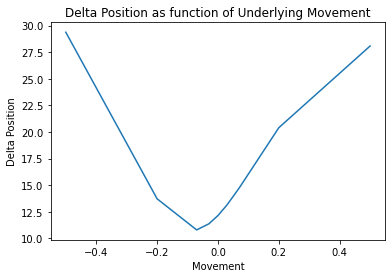

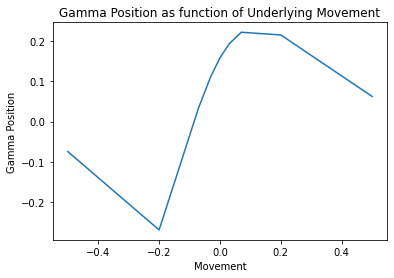

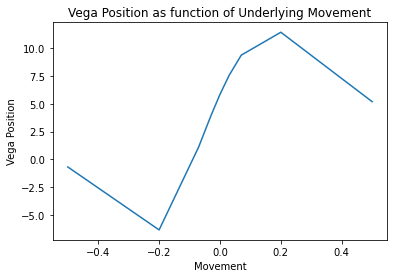

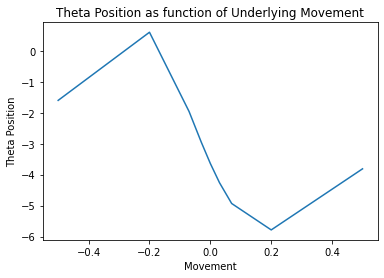

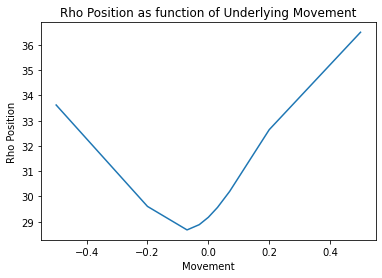

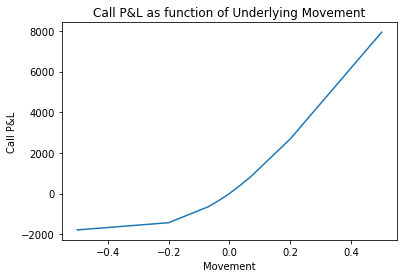

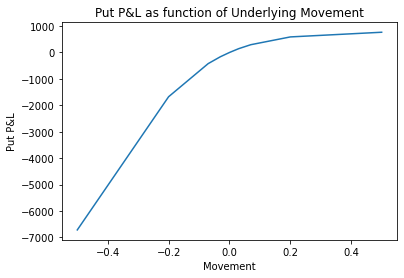

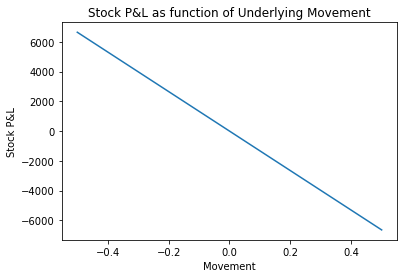

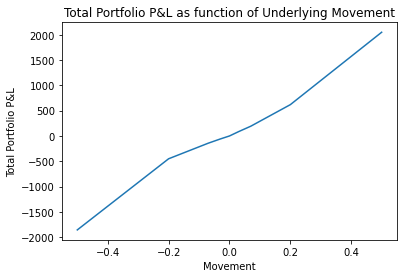

In [104]:
plt.plot(pnl_df["Movement"], pnl_df["Delta Position"])
plt.xlabel("Movement")
plt.ylabel("Delta Position")
plt.title("Delta Position as function of Underlying Movement")
plt.show()

plt.plot(pnl_df["Movement"], pnl_df["Gamma Position"])
plt.xlabel("Movement")
plt.ylabel("Gamma Position")
plt.title("Gamma Position as function of Underlying Movement")
plt.show()

plt.plot(pnl_df["Movement"], pnl_df["Vega Position"])
plt.xlabel("Movement")
plt.ylabel("Vega Position")
plt.title("Vega Position as function of Underlying Movement")
plt.show()

plt.plot(pnl_df["Movement"], pnl_df["Theta Position"])
plt.xlabel("Movement")
plt.ylabel("Theta Position")
plt.title("Theta Position as function of Underlying Movement")
plt.show()

plt.plot(pnl_df["Movement"], pnl_df["Rho Position"])
plt.xlabel("Movement")
plt.ylabel("Rho Position")
plt.title("Rho Position as function of Underlying Movement")
plt.show()

plt.plot(pnl_df["Movement"], pnl_df["Call P&L"])
plt.xlabel("Movement")
plt.ylabel("Call P&L")
plt.title("Call P&L as function of Underlying Movement")
plt.show()

plt.plot(pnl_df["Movement"], pnl_df["Put P&L"])
plt.xlabel("Movement")
plt.ylabel("Put P&L")
plt.title("Put P&L as function of Underlying Movement")
plt.show()

plt.plot(pnl_df["Movement"], pnl_df["Stock P&L"])
plt.xlabel("Movement")
plt.ylabel("Stock P&L")
plt.title("Stock P&L as function of Underlying Movement")
plt.show()

plt.plot(pnl_df["Movement"], pnl_df["Total Portfolio P&L"])
plt.xlabel("Movement")
plt.ylabel("Total Portfolio P&L")
plt.title("Total Portfolio P&L as function of Underlying Movement")
plt.show()

## Appendix
### We need a way to estimate the volatility of the stock to put into the model. Otherwise, we will arrive at unrealistic prices. 
To do so, we download the historical stock price data through the Yahoo Finance API and simply calculate the historic realized volatility of the previous year. This should be a reliable proxy for volatility going forward.

In [105]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def fetch_stock_data(ticker, period='1y'):
    # Download historical stock data for Ticker from Yahoo Finance
    stock_data = yf.Ticker(ticker)
    hist = stock_data.history(period=period)
    return hist

def calculate_realized_volatility(hist):
    # Calculate daily returns
    hist['Return'] = hist['Close'].pct_change()

    # Calculate the standard deviation of daily returns
    volatility = np.std(hist['Return'].dropna())
    
    # Annualize the volatility (assuming 252 trading days in a year)
    annualized_volatility = volatility * np.sqrt(252)

    return annualized_volatility

ticker = 'TSLA'  # Ticker for Stock we are trading
period = '1y'  # Period for historical data

# Fetch historical stock data
hist = fetch_stock_data(ticker, period)

# Calculate realized volatility
print("Last year, the realized volatilty was: " + str(calculate_realized_volatility(hist)))

Last year, the realized volatilty was: 0.5115657804828238
